In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np
import os
import cv2
import imageio
import pickle
from src.data_loading import loading
from src.modeling.run_model_single import (
    load_model, load_inputs, process_augment_inputs, batch_to_tensor
)

import src.utilities.pickling as pickling

In [17]:
shared_parameters = {
    "device_type": "cpu",
    "gpu_number": 0,
    "max_crop_noise": (100, 100),
    "max_crop_size_noise": 100,
    "batch_size": 1,
    "seed": 0,
    "augmentation": True,
    "use_hdf5": True,
}

In [18]:
image_heatmaps_parameters = shared_parameters.copy()
image_heatmaps_parameters["view"] = "R-CC" # Elegir la vista ------------------------------------------------------
cropped_name = "cropped_rcc"# Elegir la vista ------------------------------------------------------
image_heatmaps_parameters["use_heatmaps"] = True
image_heatmaps_parameters["model_path"] = "models/ImageHeatmaps__ModeImage_weights.p"
model, device = load_model(image_heatmaps_parameters)

In [19]:
random_number_generator = np.random.RandomState(shared_parameters["seed"])

In [20]:
# folder path
dir_path = r'HeatMaps/' + cropped_name + '/'
# list to store files
res = [] # files name
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)

In [21]:
# max_value = []
#for i in range(0, 191, 1):
    i = 56
    res1 = str(res[i])
    model_input = load_inputs(
        image_path="HeatMaps/"+ cropped_name + '/'+ res[i],
        metadata_path="HeatMaps/pkl_files/" + res1.split(".")[0] + ".pkl",
        use_heatmaps=True,
        benign_heatmap_path="sample_output/heatmaps/heatmap_benign/" + res1.split(".")[0] + ".hdf5",
        malignant_heatmap_path="sample_output/heatmaps/heatmap_malignant/" + res1.split(".")[0] + ".hdf5",
    )
    
    bat, borderss = process_augment_inputs(model_input=model_input, random_number_generator=random_number_generator, parameters=image_heatmaps_parameters)
    batch = [bat]
    tensor_batch = batch_to_tensor(batch, device)
    y = tensor_batch[0].cpu().numpy()
    heatmap2 = y[2]/np.max(y[2])#0.99752223
    # malignant = np.uint8(255*heatmap)
    with open("HeatMaps/pkl_files/" + res1.split(".")[0] + ".pkl", "rb") as f:
        exam_list = pickle.load(f)
    datum = exam_list
    # max_value.append((np.max(x[2])))
    img = cv2.imread("HeatMaps/"+ cropped_name + '/'+ res[i])
    
    if (image_heatmaps_parameters["view"] == "R-MLO")or(image_heatmaps_parameters["view"] == "R-CC"):
        img2 = cv2.flip(img, 1)   
    else:
        img2 = img
    cropped_image = img2[borderss[0]: borderss[1], borderss[2]: borderss[3]]
    
 
    if (np.shape(y[0]) != np.shape(cropped_image[:,:,1])):
        if (image_heatmaps_parameters["view"] == "L-MLO") or (image_heatmaps_parameters["view"] == "R-MLO"):
            newc = np.zeros((np.shape(y[0])[0],np.shape(y[0])[1],3),np.uint8)
            newc[0:np.shape(cropped_image)[0],0:np.shape(cropped_image)[1],:] = cropped_image
            heatheat = heatmap2[0:np.shape(cropped_image)[0],0:np.shape(cropped_image)[1]]
        else:
            newc = np.zeros((np.shape(y[0])[0],np.shape(y[0])[1],3),np.uint8)
            A = int((np.shape(y[0])[0]-np.shape(cropped_image)[0])/2)
            newc[A:A+np.shape(cropped_image)[0],0:np.shape(cropped_image)[1],:] = cropped_image
            heatheat = heatmap2[A:A+np.shape(cropped_image)[0],0:np.shape(cropped_image)[1]]
    else:
        newc = cropped_image
        heatheat = heatmap2
    
    heatheat2 = np.zeros((np.shape(img)[0],np.shape(img)[1]))
    heatheat2[borderss[0]: borderss[1], borderss[2]: borderss[3]] = heatheat
    #assert np.shape(y[0]) == np.shape(cropped_image[:,:,1])
    if (image_heatmaps_parameters["view"] == "R-MLO")or(image_heatmaps_parameters["view"] == "R-CC"):
        heatheat3 = cv2.flip(heatheat2, 1)   
    else:
        heatheat3 = heatheat2
    imht = np.uint8(255*heatheat3)
    ###imageio.imsave('HeatMaps/GrayHeatmapsDmvcnn/' + res1.split(".")[0] + '_CAM3.png', imht)
    print(i)
    
    imhts = cv2.applyColorMap(imht, cv2.COLORMAP_JET)
    superimposed_img = imhts* 0.4 + img*0.6#OriginalCropped
    cv2.imwrite('sample_output/ColorHeatmaps/' + res1.split(".")[0] + '_CAM3_EXAMPLE.jpg', superimposed_img)
    


56


True

In [22]:
print(np.shape(newc))
print(np.shape(y[0]))

(2677, 1942, 3)
(2677, 1942)


In [23]:
print(np.shape(cropped_image))
print(np.shape(heatheat))

(2677, 1920, 3)
(2677, 1920)


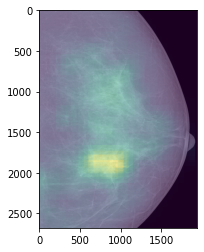

In [24]:
plt.imshow(y[0], cmap="gray")
plt.imshow(heatmap2, alpha=0.4)

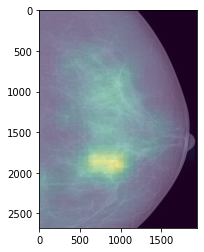

In [25]:
plt.imshow(newc, cmap="gray")
plt.imshow(heatmap2, alpha=0.4)

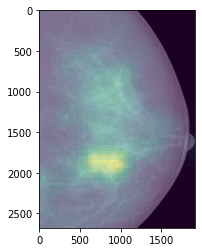

In [26]:
plt.imshow(cropped_image, cmap="gray")
plt.imshow(heatheat, alpha=0.4)

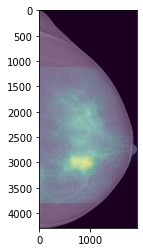

In [27]:
plt.imshow(img2)
plt.imshow(heatheat2, alpha=0.4)

In [14]:
print(np.shape(img2))
print(np.shape(heatheat2))

(4292, 1920, 3)
(4292, 1920)


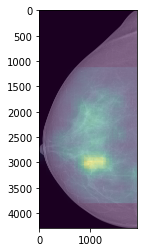

In [15]:
plt.imshow(img)
plt.imshow(heatheat3, alpha=0.4)